# Random Coefficients Logit Demand Model

### Econometrics B (ØkB)

**Bertel Schjerning**  
Department of Economics, University of Copenhagen  

### Readings:
- **Conlon & Gortmaker (2020).** ["Best Practices for Differentiated Products Demand Estimation with PyBLP."](https://doi.org/10.1111/1756-2171.12352) *RAND Journal of Economics*, 51(4), 1108–1161.

### More readings
  3. **B**erry, **L**evinsohn, & **P**akes (1995) - BLP demand model
  4. Nevo (2000) - A practitioner's guide to random coefficients logit
  5. Petrin (2002) - Quantifying benefits of new products
  6. Berry, Levinsohn, & Pakes (2004) - Micro and macro data in demand estimation
  1. Berry & Haile (2021) - Foundations of demand estimation
  2. Conlon & Gortmaker (2025) - Incorporating microdata into BLP with PyBLP

None of these are required but are recommended for further study. See full refeference list at last slide 



## **Part 1**: OLS and IV estimation of logit demand model with $\mu_{ijt}=0$
$$
            \log\frac{s_{jt}}{s_{0t}} = \delta_{jt} = \alpha p_{jt} + x_{jt}'\beta + \xi_{jt}
$$

## Initial setup of libraries

In [1]:
# For debugging
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import mymlr as mlr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time
# Matrix inversion shorthand
inv = np.linalg.inv


# Set up the display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.float_format', '{:g}'.format)

## Read the data from and Greico et al. (2024) and create variables

In [2]:
# Load data and add constant
df = pd.read_csv("cars.csv")
df["const"] = 1  

# Compute market shares and outside good share
df["s_jt"] = df["sales"] / (df["number_households"] / 2.5)
df["s_0t"] = 1 - df.groupby("year")["s_jt"].transform("sum")

# Log-difference of shares
df["dlogs_jt"] = np.log(df["s_jt"]) - np.log(df["s_0t"])

# Create dummies (drop reference categories)
year_dummies = pd.get_dummies(df["year"], prefix="y").drop(columns="y_1980", errors="ignore")
make_dummies = pd.get_dummies(df["make"]).drop(columns="volvo", errors="ignore")
df = pd.concat([df, year_dummies, make_dummies], axis=1)

# Dummy variable groups
D_year, D_make = year_dummies.columns.tolist(), make_dummies.columns.tolist()
D_type = ["sport", "EV", "truck", "suv", "van"]

# Log-transform selected variables
X_var = ["height", "hp", "mpg", "weight", "footprint", "number_trims"]
df[[f"log_{x}" for x in X_var]] = np.log(df[X_var])
X_var = [f"log_{x}" for x in X_var] + ["releaseYear", "yearsSinceDesign"]

## Estimation using OLS and IV

In [3]:
# Define LHS variable
delta = df["dlogs_jt"]
# Define RHS variable sets
c = df[["const"]]
X_sets = [
    c, 
    df[["const"] + X_var], 
    df[["const"] + X_var + D_type], 
    df[["const"] + X_var + D_type + D_year], 
    df[["const"] + X_var + D_type + D_year + D_make]
]
# Run OLS regressions
results = [mlr.ols(delta, pd.concat([X1, df["price"]], axis=1), robust=True) for X1 in X_sets]
# Run IV regression
results.append(mlr.tsls(y=delta, X1=X_sets[-1], X2=df["price"], Ze=df["RXR"], robust=True))
# Regression summary
column_titles = ["p", "p+X", "p+X+t", "p+X+t+y", "p+X+t+y+m", "p+X+t+y+m (IV)"]
mlr.summary(results, column_titles=column_titles, print_regressors=["price"] + X_var)

                            p        p+X      p+X+t    p+X+t+y  p+X+t+y+m p+X+t+y+m (IV)
Dependent variable [dlogs_jt] [dlogs_jt] [dlogs_jt] [dlogs_jt] [dlogs_jt]     [dlogs_jt]
             price    -0.0373    -0.0203    -0.0179    -0.0298    -0.0337        -0.1694
                     (0.0010)   (0.0014)   (0.0014)   (0.0014)   (0.0017)       (0.0269)
        log_height               -0.8774    -2.2726    -1.2168    -0.8707        -3.1315
                                (0.2059)   (0.2864)   (0.2824)   (0.2723)       (0.5682)
            log_hp               -1.2029    -1.2179     0.4285     0.3750         2.6639
                                (0.0666)   (0.0679)   (0.1049)   (0.1012)       (0.4801)
           log_mpg               -1.3059    -1.2027     0.3280    -0.1240         0.5428
                                (0.0834)   (0.0883)   (0.1218)   (0.1139)       (0.2002)
        log_weight               -1.0178    -1.5160    -0.8093    -0.9774         3.7059
                     

## **Part 2**:  Solve for $\delta$ using the BLP contraction when $\mu_{ijt}=0$ and compare to $\log(\hat{s}_{jt}/\hat{s}_{0t})$
**BLP Contraction iteration:**
$$
\delta_{jt}^{k+1} = \delta_{jt}^{k} + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta^k))
$$
where $s_{jt}(\delta^k)$ is computed using the logit choice probabilities.

## Let's first implement the logit ccp's


In [4]:
# Logit choice probabilities
def logsum(v, sigma=1):
    max_v = np.max(v, axis=1)  # Max across alternatives
    exp_v = np.exp((v - max_v.reshape(-1, 1)) / sigma)
    return max_v + sigma * np.log(np.sum(exp_v, axis=1))

def logit(v, sigma=1, v0=None):
    ''' Logit probability function '''
    max_v = np.max(v, axis=1)
    exp_v = np.exp((v - max_v.reshape(-1, 1)) / sigma)
    sumexp = np.sum(exp_v, axis=1).reshape(-1, 1)
    if v0 is not None:
        sumexp += np.exp((v0 - max_v) / sigma)
    return exp_v / sumexp 


## Demand inversion using contraction mapping
To estimate **$\delta$**, we need to solve for a fixed point using on the contraction mapping, $\delta=\Gamma(\delta)$

$$
\Gamma(\delta) = \delta + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta))
$$
- $\hat{s}_{jt}$ is the observed market share.
- $s_{jt}(\delta)$ is the predicted market share given current $\delta$.
- The mapping ensures that the predicted shares match the observed shares at convergence.

In [5]:
# Compute conditional choice probabilities (CCP) in the data
def predicted_share_logit(df, delta):
    N = len(df)  # Number of observations
    ccp_jt = np.zeros((N, 1))  # (N x 1)

    years = df["year"].unique() 
    for year in years:
        iy = df["year"] == year 
        delta_y = delta[iy].reshape(1, -1)  # (1 x Jt)
        ccp_jt[iy] = logit(delta_y, v0=0).reshape(-1, 1)  # (Jt x 1)
    return ccp_jt  # (N x 1)

# Contraction mapping
def contraction_logit(delta): 
    s_jt=df[["s_jt"]].values
    return delta + np.log(s_jt) - np.log(predicted_share_logit(df, delta))


## **Solving Fixed Points using Successive Approximations**

### **Fixed Point Algorithm: Successive Approximations**
1. **Choose an initial guess** $\delta^{(0)}$ (e.g., zeros or log differences of market shares).
2. **Apply the contraction mapping** iteratively:
   - Compute the update $\delta^{(k+1)} = \Gamma(\delta^{(k)})$.
   - Check for convergence $||\delta^{(k+1)} - \delta^{(k)}|| < \text{tolerance}$.
3. **Stop when convergence is achieved**.

### **Why does this work?**
- The operator $\Gamma(\delta)$ is a **contraction mapping**, meaning that it satisfies:

$$
\|\Gamma(\delta') - \Gamma(\delta)\| \leq A \|\delta' - \delta\|, \quad \text{for some } A < 1.
$$

- This guarantees that **successive approximations** converge to the unique fixed point $\delta=\Gamma(\delta)$.
- Each iteration **shrinks** the difference between successive estimates of $\delta$:

$$
\|\Gamma(\delta^{(k+1)}) - \Gamma(\delta^{(k)})\| \leq A \|\delta^{(k+1)} - \delta^{(k)}\|
$$

- **Ensures convergence** under contraction mapping properties, since $A < 1$, which holds for the BLP contraction.
- **Computationally efficient** for large-scale demand models.

## Method of successive approximations

In [6]:
def solve_sa(F, x0, maxiter=100, tol=1e-6, verbose='on'):
    ''' Solve fixed point using successive approximations
        parameters:
            F: function to solve
            x0: initial guess
            maxiter: maximum number of iterations
            tol: tolerance for convergence
            verbose: 
                'on' (default: print only if convergence is achieved)
                'notify' (print only if convergence is not achieved)
                'iter' (print every iteration)
                'off' (no print)
        returns:
            x1: fixed point
    '''
    if verbose in ['on', 'iter']:
        print('Solving fixed point using successive approximations')
    if verbose=='iter': 
        print(f'Iter   ||x1-x0||')
    for iter in range(maxiter): 
        x1=F(x0)  # Fixed point iteration
        metric=np.max(np.abs(x1-x0))
        if verbose=='iter': 
            print(f"{iter:<4d} {metric:10.4g}")  
        if metric < tol:
            if verbose in ['on', 'iter']:
                print(f'Convergence achieved after {iter+1} iteration(s)')
                print(f'||x1-x0||= {metric:<g} <tol={tol}\n')
            return x1
        x0=x1 # prepare for next iteration 
    
    if verbose in ['on', 'iter', 'notify']:
        print(f'Convergence failed after {iter+1} iterations') 
        print(f'||x1-x0||= {metric:<g} <tol={tol}\n')
    return x1

## Solve for $\delta$ using contraction iterations

In [7]:
# Initial guess for delta (e.g., zero vector)
delta_init = np.zeros((len(df),1)) # Initialize delta at zeros
# delta_init= df[["dlogs_jt"]].values # Uncomment to initialize delta at log differences of market shares

# Solve for delta
delta_hat = solve_sa(contraction_logit, delta_init, verbose='iter', tol=1e-10, maxiter=200)

Solving fixed point using successive approximations
Iter   ||x1-x0||
0         9.773
1         1.488
2          1.44
3         1.263
4        0.9047
5        0.6763
6        0.4558
7        0.2745
8        0.1407
9       0.06487
10      0.02825
11      0.01198
12     0.005023
13     0.002096
14    0.0008723
15    0.0003628
16    0.0001509
17    6.271e-05
18    2.631e-05
19     1.11e-05
20     4.68e-06
21    1.974e-06
22    8.324e-07
23    3.511e-07
24    1.481e-07
25    6.244e-08
26    2.633e-08
27    1.111e-08
28    4.684e-09
29    1.975e-09
30    8.331e-10
31    3.513e-10
32    1.482e-10
33    6.249e-11
Convergence achieved after 34 iteration(s)
||x1-x0||= 6.2494e-11 <tol=1e-10



## Veryfy that predicted market shares equals observed market shares at our solution of $\delta$

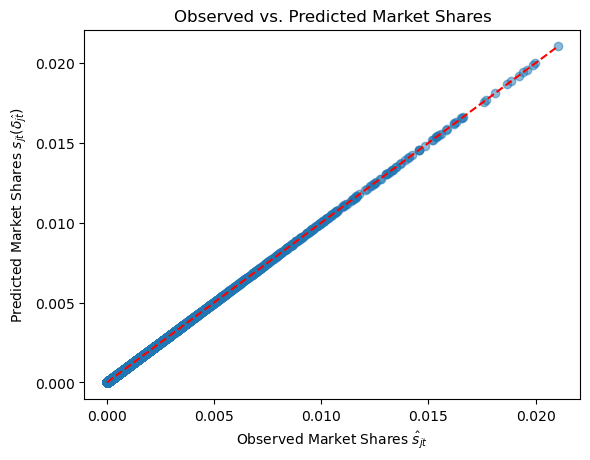

In [8]:
# Compute predicted market shares using estimated delta
s_jt_pred = predicted_share_logit(df, delta_hat)

# Scatter plot: Observed vs. Predicted market shares
plt.scatter(df["s_jt"], s_jt_pred, alpha=0.5)
plt.plot([0, max(df["s_jt"])], [0, max(df["s_jt"])], 'r--')  # 45-degree line
plt.xlabel(r"Observed Market Shares $\hat{s}_{jt}$")
plt.ylabel(r"Predicted Market Shares $s_{jt}(\delta_{\hat{jt}})$")
plt.title(r"Observed vs. Predicted Market Shares")
plt.show()

## **Contraction Mapping Finds $\delta$**
- We solve for $\delta$ using **successive approximations** on the BLP contraction:
  $$
  \delta_{jt}^{k+1} = \delta_{jt}^{k} + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta^k))
  $$
- When initialized at **zero**, the contraction mapping converges to the correct $\delta$.
- When initialized at **log differences of market shares** (the solution), it converges in **one iteration**.
- The **scatter plot** of observed vs. predicted shares aligns along the **45-degree line**, verifying our implementation.

## **Part 3**: Estimate $\beta$ using GMM with $\delta$ from Contraction Mapping and compare to IV


## Moment conditions and GMM Objective

The **moment conditions** in the GMM estimation are given by:

$$
\mathbb{E}[\xi_{jt} z_{jt}] = 0, \quad \text{where } \xi_{jt} = \delta_{jt} - X_{jt} \beta
$$

The corresponding **sample moment conditions** are:

$$
g(\beta) = \frac{1}{N} Z' \xi = \frac{1}{N} Z' (\delta - X \beta)
$$

The **GMM objective estimator** minimizes the weighted quadratic form of the moments:

$$
Q(\beta) = g(\beta)' W g(\beta)
$$

where \( W \) is a positive definite weighting matrix.

In [9]:
# Compute GMM moment conditions
def gmm_moments(theta, X, Z, delta):
    """ Compute moment conditions g(β) = (Z' ξ) / N """
    theta=theta.reshape(-1, 1) # ensure that theta is Kx1
    xi = delta - X @ theta  # Structural error term (N, 1)
    g = (Z.T @ xi) / len(delta)  # Moment conditions (q, 1)
    return g

# Compute the GMM objective function g' W g (returns scalar)
def gmm_objective(theta, X, Z, delta, W):
    """ Compute the GMM objective function g' W g """
    g = gmm_moments(theta, X, Z, delta)  # (q, 1)
    return (g.T @ W @ g).item()  # Ensure scalar output

## GMM estimation

In [10]:
# Convert pandas DataFrame/Series to NumPy arrays
def pd_to_arrays(vars):
    return [var.to_frame().values if isinstance(var, pd.Series) else var.values for var in vars]

# Construct matrices X (regressors) and Z (instruments)
def build_X_Z(X1, X2, Ze):
    X1, X2, Ze = [pd.DataFrame(var) for var in [X1, X2, Ze]]
    X = pd.concat([X2, X1], axis=1)  # Combine X1 and X2 (n x k)
    Z = pd.concat([X1, Ze], axis=1)  # Combine X2 and Ze (n x q)
    return pd_to_arrays([X, Z])  # Convert to NumPy arrays

# Estimate parameters using GMM
def gmm_estimate(X1, X2, Ze, delta, verbose=True):
    """ Estimate beta using GMM """
    X, Z = build_X_Z(X1, X2, Ze)

    # Define W using the correct dimension
    W = np.eye(Z.shape[1])  

    # Ensure `W` is square
    assert W.shape == (Z.shape[1], Z.shape[1]), f"Weighting matrix W must be square, got {W.shape}"

    # Initial estimate using OLS
    beta_ols = inv(X.T @ X) @ X.T @ delta  
    
    # Estimate beta_hat using "2SLS" formula: β = (X'PzX)^(-1) * X'Pz*y
    Pz = Z @ inv(Z.T @ Z) @ Z.T  # (n x n) projection matrix (to get X predicted by Z)
    X_hat = Pz @ X  # (n x k2)    
    beta_2sls = inv(X.T@Pz@X) @ X.T@Pz@delta  # (k1 + k2 x 1)

    beta_init=beta_ols
    
    # Optimize GMM objective function
    start_time = time.perf_counter()
    res = opt.minimize(gmm_objective, beta_init.flatten(), args=(X, Z, delta, W),
                       method='BFGS', options={'disp': verbose})
    end_time = time.perf_counter()

    # Display timing
    if verbose:
        print(f"Optimization completed in {end_time - start_time:.6f} seconds")

    return res.x.reshape(-1,1), res

## Extract relevant variables and estimate model using non-linear GMM, OLS and IV

In [11]:
# Extract relevant variables and estimate model using non-linear GMM, OLS and IV
X2 = df[["price"]]  # Endogenous regressor: price
X1 = df[["const"]]  # Exogenous variables (e.g., constant term)
X1 = df[["const"] + X_var + D_type + D_year + D_make]  # Exogenous variables
X1 = df[["const"]]  # Exogenous variables
Ze = df[["RXR"]]  # External instruments
delta = delta_hat  # Estimated delta from contraction
df['delta']=delta_hat

# Run GMM estimation
beta_hat_gmm, res_gmm = gmm_estimate(X1, X2, Ze, delta)

# Display results
np.set_printoptions(precision=4, suppress=True, floatmode='maxprec_equal')
print("\nEstimated β_price using GMM:", beta_hat_gmm[0].T)

m2sls=mlr.tsls(y=df['delta'], X1=X1, X2=X2, Ze=Ze, robust=True)
m2ols=mlr.ols(df['delta'], pd.concat([X2, X1], axis=1), robust=True)

mlr.summary([m2ols, m2sls], column_titles=['OLS', 'IV'], print_regressors=["price" ,'const'] + X_var)
# mlr.summary([m2ols, m2sls], column_titles=['OLS', 'IV'])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization completed in 0.001948 seconds

Estimated β_price using GMM: [-0.0975]
                          OLS         IV
Dependent variable    [delta]    [delta]
             price    -0.0373    -0.0975
                     (0.0010)   (0.0040)
             const    -5.9072    -3.7399
                     (0.0426)   (0.1428)
         R_squared     0.1062    -0.1693
               TSS 37300.6952 37300.6952
               RSS 33339.4749 43617.0537
               ESS  3961.2203 -6316.3585
                 n       9694       9694
Note: Standard errors are reported in parentheses.
Only showing subset of regressors.




## References
- Berry, S. (1994). ["Estimating Discrete-Choice Models of Product Differentiation."](https://www.jstor.org/stable/2555829) *RAND Journal of Economics*, 25(2), 242–262.
- Berry, S., & Pakes, A. (2007). ["The Pure Characteristics Demand Model."]( https://doi.org/10.1111/j.1468-2354.2007.00459.x) *International Economic Review*, 48(4), 1193–1225.
- Berry, S., Levinsohn, J., & Pakes, A. (1995). ["Automobile Prices in Market Equilibrium."](https://www.jstor.org/stable/2171802) *Econometrica*, 63(4), 841–890.
- Berry, S., Levinsohn, J., & Pakes, A. (2004). ["Differentiated Products Demand Systems from a Combination of Micro and Macro Data: The New Car Market."](https://www.journals.uchicago.edu/doi/10.1086/379939) *Journal of Political Economy*, 112(1), 68–105.
- Berry, S., & Haile, P. (2021). ["Foundations of Demand Estimation."](https://doi.org/10.1016/bs.hesind.2021.11.001) In *Handbook of Industrial Organization* (Vol. 4), pp. 1–62.
- Conlon, C., & Gortmaker, J. (2020). ["Best Practices for Differentiated Products Demand Estimation with PyBLP."](https://doi.org/10.1111/1756-2171.12352) *RAND Journal of Economics*, 51(4), 1108–1161.
- Conlon, C., & Gortmaker, J. (2025). ["Incorporating Microdata into Differentiated Products Demand Estimation with PyBLP."](https://doi.org/10.1016/j.jeconom.2024.105926), *Journal of Econometrics*, forthcoming
- DellaVigna, S., & Gentzkow, M. (2019). ["Uniform Pricing in US Retail Chains."](https://academic.oup.com/qje/article/134/4/2011/5549382) *Quarterly Journal of Economics*, 134(4), 2011–2084.
- Hausman, J. (1996). ["Valuation of New Goods Under Perfect and Imperfect Competition."](https://www.nber.org/chapters/c6068) In *The Economics of New Goods* (University of Chicago Press), pp. 207–248.
- Nevo, A. (2000). ["A Practitioner's Guide to Estimation of Random-Coefficients Logit Models of Demand."](https://doi.org/10.1111/j.1430-9134.2000.00513.x) *Journal of Economics & Management Strategy*, 9(4), 513–548.
- Petrin, A. (2002). ["Quantifying the Benefits of New Products: The Case of the Minivan."](https://www.journals.uchicago.edu/doi/10.1086/340779) *Journal of Political Economy*, 110(4), 705–729.